# <center>MethaneSAT maps with matplotlib</center>

This notebooks shows how to plot MethaneSAT L2 data over a background tile using matplotlib.<br>

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) # full width notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
from pyproj import Transformer
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from netCDF4 import Dataset

In [3]:
plt.rcParams.update({"font.size":10})

In [4]:
def mpl_ctx_plot(
    cax,
    lon: np.ndarray,
    lat: np.ndarray,
    z: np.ndarray,
    cb_label: str = "",
    cb_fraction: float = 0.04,
    latlon_padding: float = 0,
    latlon_step: float = 0.5,
    lab_prec: int = 1,
    tile_source: str = "https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}",
    **kwargs,
):
    """
    ax: matplotlib axes
    lon (np.ndarray): longitude
    lat (np.ndarray): latitude
    z (np.ndarray): variable for the heatmap
    cb_label (str): colorbar label
    cb_fraction (float): control the size of the colorbar
    latlon_padding (float): add above/below the max/min lat and lon
    latlon_step (float): the spacing between lat/lon ticks
    lab_prec (int): number of decimals for the lat/lon tick labels
    kwargs: passed to the pcolormesh call
    """
    lon_min, lon_max = np.nanmin(lon)-latlon_padding, np.nanmax(lon)+latlon_padding
    lat_min, lat_max = np.nanmin(lat)-latlon_padding, np.nanmax(lat)+latlon_padding
    
    # round to nearest .5
    lon_start = np.floor(lon_min*2)/2
    lat_start = np.floor(lat_min*2)/2
    
    delta_lat = lat_max-lat_min
    delta_lon = lon_max-lon_min
    n_ticks = np.max([int(delta_lat/latlon_step)+2,int(delta_lon/latlon_step)+2])
    lon_ticks = lon_start + np.arange(n_ticks)*latlon_step
    lat_ticks = lat_start + np.arange(n_ticks)*latlon_step
    
    # The background tiles are on Web Mercator
    # Transform coordinates to Web Mercator (EPSG:3857)
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)

    # Transform lon/lat ticks to x/y in Web Mercator projection
    x_ticks, y_ticks = transformer.transform(lon_ticks, lat_ticks)

    # Now transform the main lon, lat arrays for plotting (after tick creation)
    x, y = transformer.transform(lon, lat)
    xmin, ymin = transformer.transform(lon_min, lat_min)
    xmax, ymax = transformer.transform(lon_max, lat_max)
    
    m = cax.pcolormesh(x,y,z,**kwargs)
    plt.colorbar(m,ax=cax,label=cb_label,extend="both",fraction=cb_fraction)

    # Format longitude/latitude labels
    def format_latlon(value, is_lon):
        """
        Format the lat/lon to show degrees and direction (N, S, E, W).
        """
        if is_lon:
            direction = 'E' if value >= 0 else 'W'
            value = abs(value)
        else:
            direction = 'N' if value >= 0 else 'S'
            value = abs(value)

        return f"{value:.{lab_prec}f}°{direction}"

    cax.set_aspect("equal")

    # Set the ticks on the plot
    cax.set_xticks(x_ticks)
    cax.set_yticks(y_ticks)
    cax.set_xlim(xmin,xmax)
    cax.set_ylim(ymin,ymax)

    # Apply formatted labels
    cax.set_xticklabels([format_latlon(lon, is_lon=True) for lon in lon_ticks])
    cax.set_yticklabels([format_latlon(lat, is_lon=False) for lat in lat_ticks])
    cax.grid(linestyle="--",alpha=0.4)
    
    # Add Google Satellite tiles as the basemap
    ctx.add_basemap(cax, source=tile_source, crs="EPSG:3857")

    # Add scalebar
    scalebar = AnchoredSizeBar(
        cax.transData,                # Transformation to use
        50000,                        # Length of the scalebar in data units (e.g., 100 km = 100,000 meters for Web Mercator)
        '50 km',                      # Label for the scalebar
        'lower left',                 # Location of the scalebar
        pad=0.3,                      # Padding around the scalebar
        color='white',                # Color of the scalebar
        frameon=False,                # Remove the surrounding frame
        size_vertical=500,            # Thickness of the scalebar
        fontproperties=fm.FontProperties(size=12),  # Font size of the label
        label_top=True,               # Label above the scalebar
    )
    cax.add_artist(scalebar)

## Read data

In [ ]:
with Dataset("manual/t65/2024/09/22/01980410/level2-results/MSAT_L2_post_20240922T103449_20240922T103521_manualdestripe.nc") as f:
    lon = f["geolocation/longitude"][:].filled(np.nan)
    lat = f["geolocation/latitude"][:].filled(np.nan)
    qf = f["product_co2proxy/main_quality_flag"][:].filled(np.nan)
    xch4 = f["product_co2proxy/xch4_co2proxy"][:].filled(np.nan)
    albedo = f["apriori_data/albedo_ch4band"][:].filled(np.nan)
xch4[qf>0] = np.nan
valid_xtrack = np.isfinite(np.nanmean(lon,axis=0))
lon = lon[:,valid_xtrack]
lat = lat[:,valid_xtrack]
xch4 = xch4[:,valid_xtrack]
albedo = albedo[:,valid_xtrack]

## Make the figure

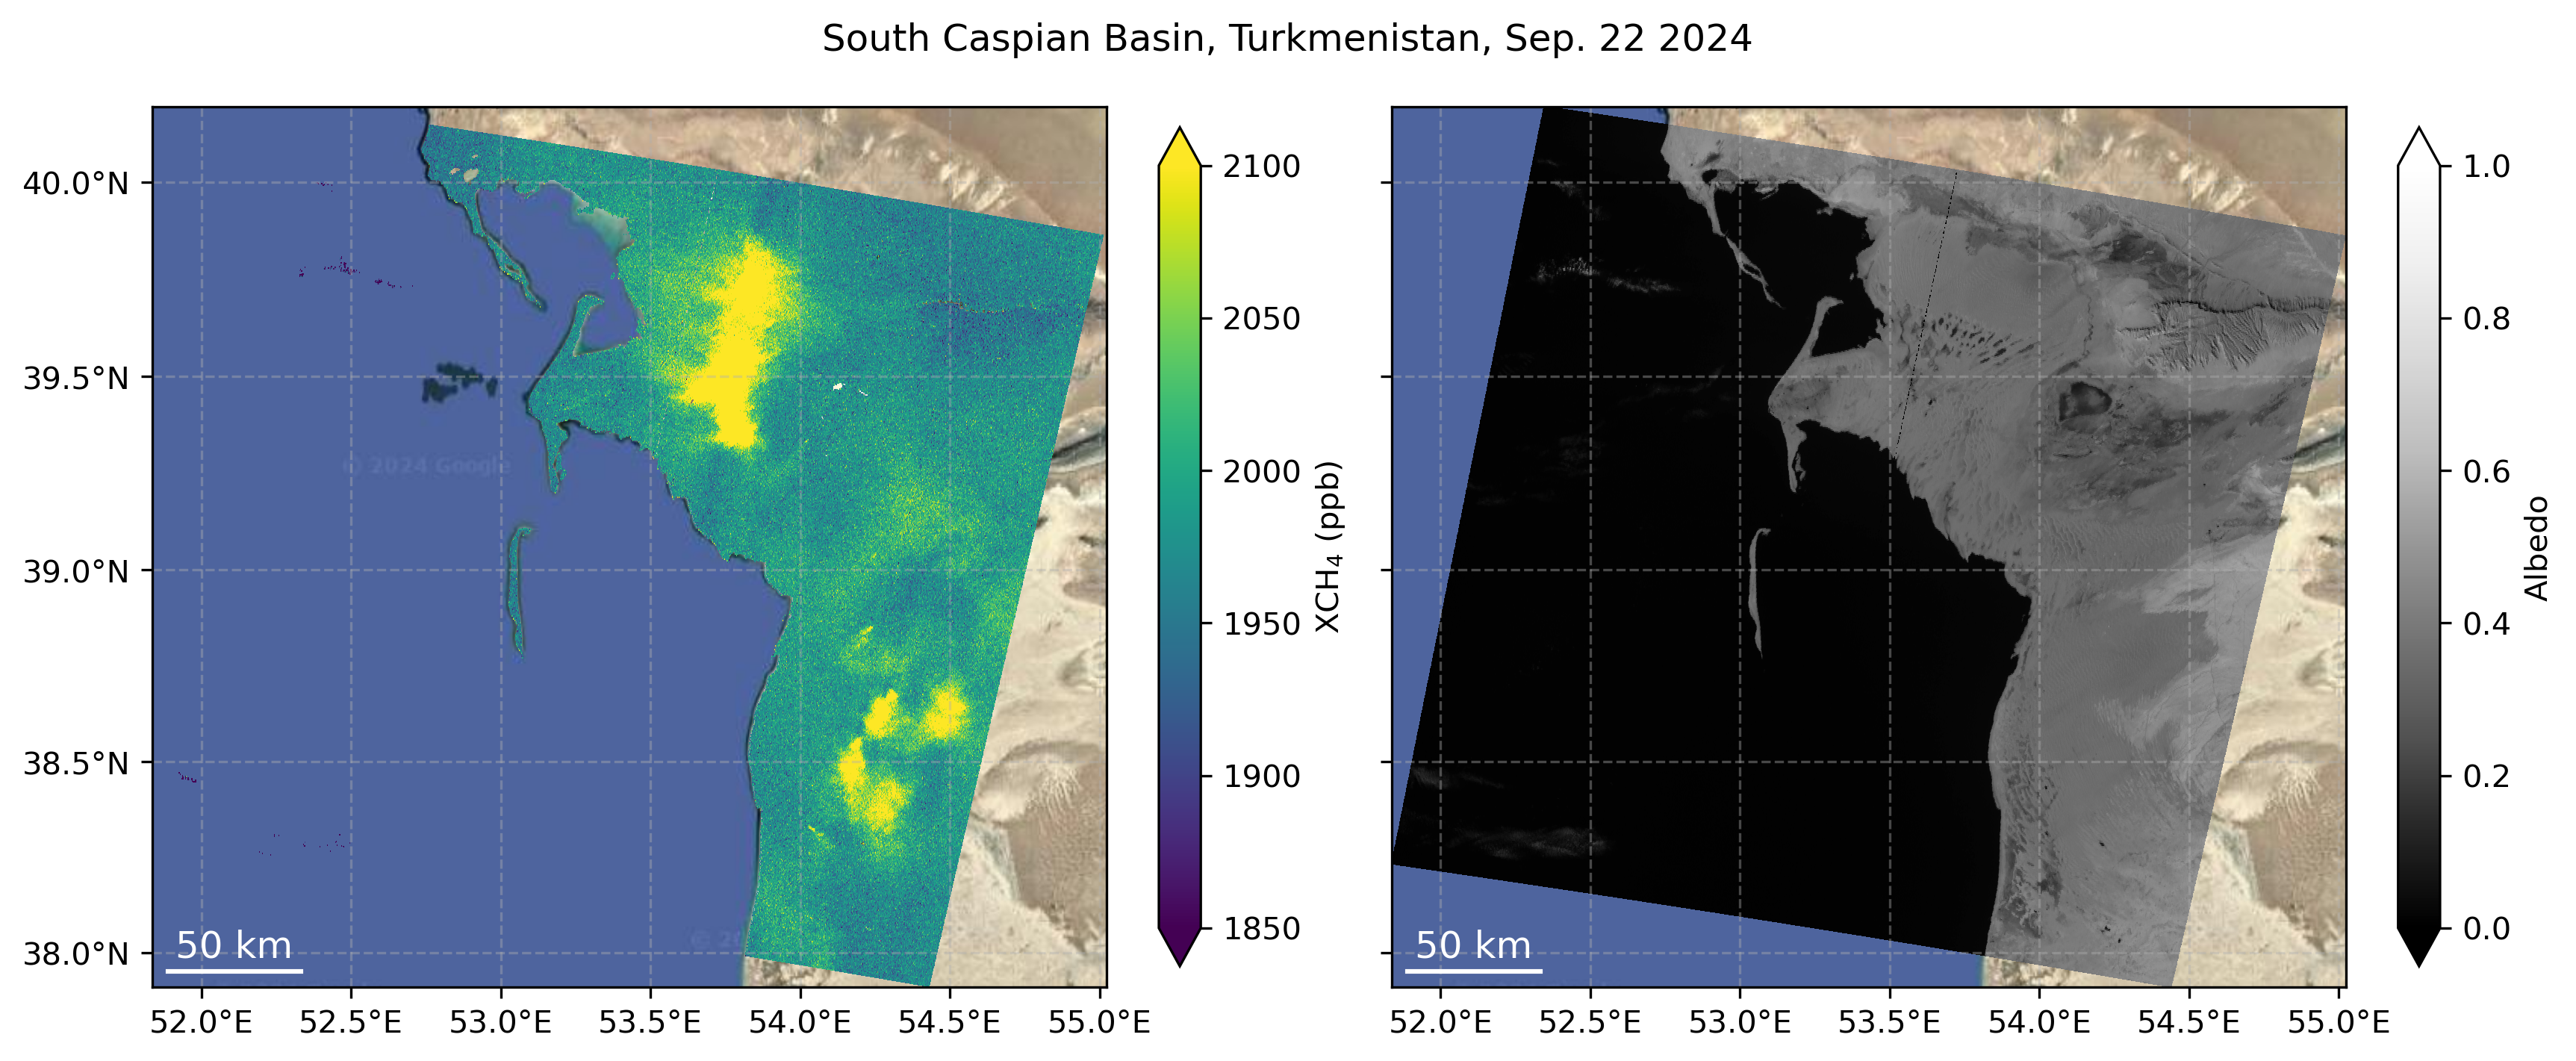

In [8]:
fig,ax = plt.subplots(1,2,sharex=True,sharey=True,figsize=(11.6,4.7),dpi=300)
mpl_ctx_plot(ax[0],lon,lat,xch4,vmin=1850,vmax=2100,cb_label="XCH$_4$ (ppb)")
mpl_ctx_plot(ax[1],lon,lat,albedo,vmin=0,vmax=1,cb_label="Albedo",cmap="Greys_r")
fig.suptitle("South Caspian Basin, Turkmenistan, Sep. 22 2024")
plt.tight_layout()